In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings(action='ignore')

In [2]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import sklearn
from sklearn.model_selection import cross_val_score

In [3]:
# xgboost 여러개의 결정트리를 임의적으로 학습하는 앙상블의 부스팅 유형 
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostRegressor
import lightgbm as lgb
import xgboost as xgb
from xgboost import XGBRegressor # 회귀트리 모델
from xgboost import plot_importance # 중요변수 시각화
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import GridSearchCV
from math import sqrt
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score

In [4]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [5]:
data = pd.read_csv('/content/nike_dunk(model)_higt_low.csv', index_col = 0)
df = data.copy()
df.head(3)

,size,price,date,product,release_date,color,release_price,brand,category,number,wish,review,transactions,type,review_log,wish_log,size_target,size_type,color_count,multicolor,color1,color2,color3,color4,Collabo,Collabo_brand,after_day,after_day_log,date_unix,release_date_unix
0,235,124000,2021-11-14,(W) Nike Dunk Low SE Primal Black,2021-11-07,BLACK/MULTI-COLOR/BLACK,129000,Nike,Nike Dunk,41947.0,93.0,4.0,30,Low,1.386295,4.5326,Female,W,3,True,BLACK,MULTI-COLOR,BLACK,NaN,False,None,7,1.945910,738108,738101
1,255,149000,2021-11-18,(W) Nike Dunk Low SE Primal Black,2021-11-07,BLACK/MULTI-COLOR/BLACK,129000,Nike,Nike Dunk,41947.0,93.0,4.0,30,Low,1.386295,4.5326,Female,W,3,True,BLACK,MULTI-COLOR,BLACK,NaN,False,None,11,2.397895,738112,738101
2,240,120000,2021-11-24,(W) Nike Dunk Low SE Primal Black,2021-11-07,BLACK/MULTI-COLOR/BLACK,129000,Nike,Nike Dunk,41947.0,93.0,4.0,30,Low,1.386295,4.5326,Female,W,3,True,BLACK,MULTI-COLOR,BLACK,NaN,False,None,17,2.833213,738118,738101


In [6]:
df.shape

(197162, 30)

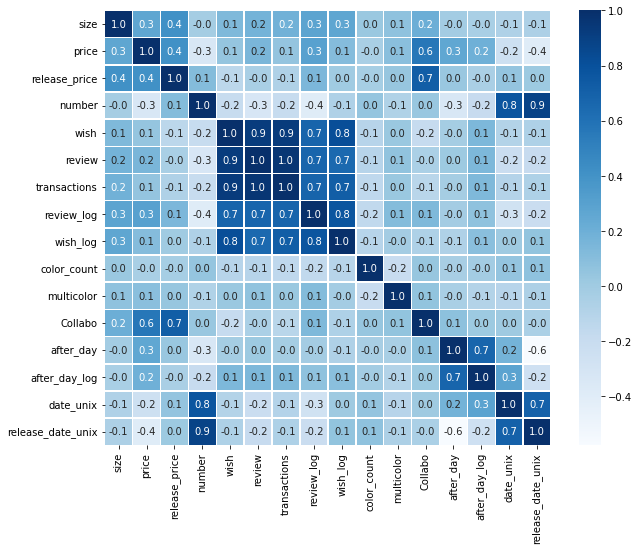

In [7]:
#  상관관계 확인 
# 전체적인 변수간 상관관계 
fig ,ax  = plt.subplots(figsize = (10,8))
c = df.corr()
sns.heatmap(c , annot = True , fmt ='.1f' , linewidths  = .5 , cmap = 'Blues')
plt.show()

In [8]:
# 남성, 여성 , 아동 
df = df.rename(columns = {'size_type':'sex'})
df.loc[(df['sex'].str.contains('W')) | (df['sex'].str.contains("GS")) , 'sex'] =  'W'
df.loc[(df['sex'].str.contains('PS')) | (df['sex'].str.contains("TD")) , 'sex'] =  'KID'
df['sex'] = df['sex'].astype(str)

In [9]:
# 컬럼 제거 
df = df.drop(['date','release_date','number','product','wish','wish_log','review','review_log','color_count','color','color1','color2','color3','color4','brand','release_date_unix','date_unix','after_day_log','size_target'],axis = 1)

In [10]:
# null 값 보기 
tot = df.isnull().sum().sort_values(ascending=False)
pct = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([tot, pct], axis=1, keys=['Total', 'Percent'])
missing_data

,Total,Percent
after_day,0,0.0
Collabo_brand,0,0.0
Collabo,0,0.0
multicolor,0,0.0
sex,0,0.0
type,0,0.0
transactions,0,0.0
category,0,0.0
release_price,0,0.0
price,0,0.0


In [11]:
df.columns

Index(['size', 'price', 'release_price', 'category', 'transactions', 'type',
       'sex', 'multicolor', 'Collabo', 'Collabo_brand', 'after_day'],
      dtype='object')

In [12]:
dataset = pd.get_dummies(df, columns = ['category', 'sex', 'multicolor', 'Collabo_brand','Collabo','type'])
dataset = dataset.drop(['size','price','release_price','transactions'
                        ,'after_day'] ,axis = 1 ) 

In [13]:
# train, test data  생성
X = df.drop(['price'], axis = 1)
y = df.price
X_train, X_test , y_train, y_test =  train_test_split(X,y , random_state = 123)

In [14]:
scaler = MinMaxScaler()
MM_cols = ['size','release_price','transactions','after_day']

#X_train_scaled = scaler.fit_transform(X_train[MM_cols])
# X_test_scaled = scaler.transform(X_test[MM_cols])


MM_train = pd.DataFrame(scaler.fit_transform(X_train[MM_cols]))
MM_test = pd.DataFrame(scaler.transform(X_test[MM_cols]))

MM_train.index = X_train.index
MM_test.index = y_test.index
                       
MM_train.columns = ['size','release_price','transactions','after_day']
MM_test.columns =  ['size','release_price','transactions','after_day']

In [15]:
X_train = pd.concat([MM_train, dataset], axis =1)
X_test = pd.concat([MM_test, dataset], axis =1)

In [16]:
X_train = X_train.dropna()
X_test = X_test.dropna()

In [17]:
display(X_train.head(3), X_test.head(3)) 

,size,release_price,transactions,after_day,category_Nike Dunk,sex_KID,sex_M,sex_W,multicolor_False,multicolor_True,Collabo_brand_Ambush,Collabo_brand_Fragment,Collabo_brand_Frame Skate,Collabo_brand_Kasina,Collabo_brand_NBA,Collabo_brand_None,Collabo_brand_Off-White,Collabo_brand_Parra,Collabo_brand_Quartersnacks,Collabo_brand_StrangeLove,Collabo_brand_Supreme,Collabo_brand_Travis Scott,Collabo_brand_Undercover,Collabo_False,Collabo_True,type_High,type_Low
0,0.645833,0.416171,0.001598,0.001077,1,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1
1,0.729167,0.416171,0.001598,0.001795,1,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1
3,0.666667,0.416171,0.001598,0.003769,1,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1


,size,release_price,transactions,after_day,category_Nike Dunk,sex_KID,sex_M,sex_W,multicolor_False,multicolor_True,Collabo_brand_Ambush,Collabo_brand_Fragment,Collabo_brand_Frame Skate,Collabo_brand_Kasina,Collabo_brand_NBA,Collabo_brand_None,Collabo_brand_Off-White,Collabo_brand_Parra,Collabo_brand_Quartersnacks,Collabo_brand_StrangeLove,Collabo_brand_Supreme,Collabo_brand_Travis Scott,Collabo_brand_Undercover,Collabo_False,Collabo_True,type_High,type_Low
2,0.666667,0.416171,0.001598,0.002872,1,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1
9,0.687500,0.416171,0.001598,0.005205,1,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1
10,0.687500,0.416171,0.001598,0.007538,1,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1


In [18]:
# 랜덤 포레스트 

rf=RandomForestRegressor(n_estimators=100, max_depth=50)
rf.fit(X_train, y_train)  

RandomForestRegressor(max_depth=50)

In [19]:
from sklearn.model_selection import RandomizedSearchCV
from pprint import pprint

In [20]:
param_grid = {
    'max_depth':[2,4,5],
    'max_leaf_nodes':[10,100,500],  
}

model = RandomForestRegressor(n_estimators=100, max_depth=10)

clf = GridSearchCV(model, cv=5,
                   param_grid=param_grid)
clf.fit(X_train, y_train) 

GridSearchCV(cv=5, estimator=RandomForestRegressor(max_depth=10),
             param_grid={'max_depth': [2, 4, 5],
                         'max_leaf_nodes': [10, 100, 500]})

In [21]:
clf.best_params_
rf_model =clf.best_estimator_
rf_model

RandomForestRegressor(max_depth=2, max_leaf_nodes=10)

In [22]:
rf = RandomForestRegressor(n_estimators= 100 , max_depth =2
                           , max_leaf_nodes = 500)
rf.fit(X_train ,y_train)

RandomForestRegressor(max_depth=2, max_leaf_nodes=500)

In [23]:
y_pred = rf_model.predict(X_test)

In [24]:
from sklearn import metrics
from sklearn.metrics import  r2_score,mean_absolute_error,mean_squared_log_error,median_absolute_error,explained_variance_score,  mean_squared_error

print('R²: %.2f' % r2_score(y_test, y_pred))
# print("mean_squared_log_error: %.2f" % mean_squared_log_error(y_test, y_pred2))
print("mean_absolute_error: %.2f" % mean_absolute_error(y_test, y_pred))
print("median_absolute_error: %.2f" % median_absolute_error(y_test, y_pred))
print("explained_variance_score: %.2f" % explained_variance_score(y_test, y_pred))

R²: -0.00
mean_absolute_error: 159627.69
median_absolute_error: 120293.10
explained_variance_score: -0.00


In [25]:
from scipy  import sqrt

In [26]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
print('XGB MAE:', mean_absolute_error(y_test, y_pred))
print('XGB RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)))

XGB MAE: 159627.68746098524
XGB RMSE: 256734.14953991876


In [27]:
param_grid = {
    "n_estimators":[100,200,300],
    "max_depth":[10, 50, 100],
    "max_features":[6,8,10,12,14,16]
}

rf_reg = RandomForestRegressor()

rf_reg_tuned = GridSearchCV(estimator=rf_reg,
                            param_grid=param_grid,
                            cv=3,
                            n_jobs=-1,
                            verbose=2)

rf_reg_tuned.fit(X_train, y_train)
rf_reg_tuned.best_estimator_

Fitting 3 folds for each of 54 candidates, totalling 162 fits


RandomForestRegressor(max_depth=10, max_features=8, n_estimators=300)

In [28]:
rf = RandomForestRegressor(n_estimators= 300 , max_depth =10
                           , max_features = 6)
rf.fit(X_train ,y_train)

RandomForestRegressor(max_depth=10, max_features=6, n_estimators=300)

In [29]:
y_pred = rf.predict(X_test)

In [30]:
print('XGB MAE:', mean_absolute_error(y_test, y_pred))
print('XGB RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)))

XGB MAE: 159780.69562688543
XGB RMSE: 256880.81251317947


In [31]:
index=rf.feature_importances_.argsort()[::-1][0:-1]
index_imp=rf.feature_importances_[index]
index_name=X_train.columns[index].tolist()
feature_importance=list(zip(index_name,index_imp))
feature_importance

[('after_day', 0.5365348307457578),
 ('size', 0.26016366427463494),
 ('transactions', 0.11012747325715642),
 ('release_price', 0.04297739811526523),
 ('type_Low', 0.006523157939618331),
 ('type_High', 0.005804547687746185),
 ('sex_W', 0.004780652192036513),
 ('sex_M', 0.004758227983056077),
 ('Collabo_brand_Parra', 0.002960844973973152),
 ('Collabo_brand_Off-White', 0.0021812578680699053),
 ('sex_KID', 0.0021581921057074833),
 ('multicolor_True', 0.002069889747981276),
 ('Collabo_brand_None', 0.0019876555363533125),
 ('Collabo_True', 0.0019312720401706623),
 ('Collabo_False', 0.0018180473116738531),
 ('multicolor_False', 0.0017575126755126282),
 ('Collabo_brand_StrangeLove', 0.0017170562354424546),
 ('Collabo_brand_Kasina', 0.0016731072247620565),
 ('Collabo_brand_Frame Skate', 0.001649940963280579),
 ('Collabo_brand_Travis Scott', 0.0012825349251533854),
 ('Collabo_brand_NBA', 0.0012003424080811811),
 ('Collabo_brand_Ambush', 0.001105235121479301),
 ('Collabo_brand_Fragment', 0.001075

In [32]:
# XGB 
xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=7)

xgb_model.fit(X_train,y_train)

[15:10:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(learning_rate=0.08, max_depth=7, subsample=0.75)

In [33]:
xgb_pred = xgb_model.predict(X_test)
xgb_pred

array([404188.03, 396814.22, 371163.75, ..., 323160.38, 327088.06,
       331703.22], dtype=float32)

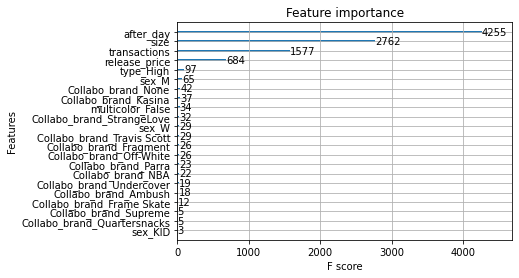

In [34]:
xgb.plot_importance(xgb_model)
plt.show()

In [35]:
print('XGB MAE:', mean_absolute_error(y_test, xgb_pred))
print('XGB RMSE:', np.sqrt(mean_squared_error(y_test, xgb_pred)))

XGB MAE: 160138.89543603294
XGB RMSE: 257353.20820413186


In [36]:
# catboost
cb_model = CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=4, l2_leaf_reg=20, 
                             bootstrap_type='Bernoulli', subsample=0.6, eval_metric='RMSE', 
                             metric_period=50, od_type='Iter', od_wait=45, random_seed=17, allow_writing_files=False)

In [37]:
cb_model = cb_model.fit(X_train, y_train, eval_set = (X_test ,y_test), early_stopping_rounds=100,verbose = False)
cb_model

In [38]:
cb_pred = cb_model.predict(X_test)
cb_pred

array([330655.22761027, 330655.22761027, 330655.22761027, ...,
       329184.71668205, 329184.71668205, 329184.71668205])

In [39]:
print('XGB MAE:', mean_absolute_error(y_test, cb_pred))
print('XGB RMSE:', np.sqrt(mean_squared_error(y_test, cb_pred)))

XGB MAE: 159600.88039461453
XGB RMSE: 256720.41419369602


In [40]:
# LightGBM
def run_lgb(X_train, y_train, X_test, y_test):
    params = {
        "objective" : "regression",
        "metric" : "rmse",
        "num_leaves" : 40,
        "learning_rate" : 0.004,
        "bagging_fraction" : 0.6,
        "feature_fraction" : 0.6,
        "bagging_frequency" : 6,
        "bagging_seed" : 42,
        "verbosity" : -1,
        "seed": 42
    }
    
    lgtrain = lgb.Dataset(X_train, label=y_train)
    lgval = lgb.Dataset(X_test, label=y_test)
    evals_result = {}
    model = lgb.train(params, lgtrain, 5000, 
                      valid_sets=[lgtrain, lgval], 
                      early_stopping_rounds=100, 
                      verbose_eval=150, 
                      evals_result=evals_result)
    
    pred_test_y = np.expm1(model.predict(X_test, num_iteration=model.best_iteration))
    return pred_test_y, model, evals_result

In [41]:
pred_test, model, evals_result = run_lgb(X_train,y_train, X_test, y_test)
print("LightGBM Training Completed...")

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[1]	training's rmse: 258966	valid_1's rmse: 256723
LightGBM Training Completed...
